## 1 - Packages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from datetime import datetime

from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
COLORS = ['#ccdbd6', '#a8af98', '#43ae9e', '#e7b24f', '#cb6e1b', '#e6d8cf', '#d7c5ad', '#a8afbb', '#7a8b9f']

In [3]:
TITLE = {'fontsize':28, 'fontstyle':'normal', 'fontfamily':'Georgia', 'backgroundcolor':'#8058af', 'color':'#ddcfed'}

## 2 - Prepare and Analyze Data

In [4]:
PATH = "/kaggle/input/svm-churn-rate/churn_rate_prediction.csv" # Path to your file

df = pd.read_csv(PATH)
df.head()
#ToDo: Show histogram of dataframe

,customer_id,Name,age,gender,security_no,region_category,membership_category,joining_date,joined_through_referral,referral_id,...,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,fffe4300490044003600300030003800,Pattie Morrisey,18,F,XW0DQ7H,Village,Platinum Membership,2017-08-17,No,xxxxxxxx,...,300.63,53005.25,17.0,781.75,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,fffe43004900440032003100300035003700,Traci Peery,32,F,5K0N3X1,City,Premium Membership,2017-08-28,?,CID21329,...,306.34,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,fffe4300490044003100390032003600,Merideth Mcmeen,44,F,1F2TCL3,Town,No Membership,2016-11-11,Yes,CID12313,...,516.16,21027.00,22.0,500.69,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,fffe43004900440036003000330031003600,Eufemia Cardwell,37,M,VJGJ33N,City,No Membership,2016-10-29,Yes,CID3793,...,53.27,25239.56,6.0,567.66,No,Yes,Yes,Unsolved,Poor Website,5
4,fffe43004900440031003900350030003600,Meghan Kosak,31,F,SVZXCWB,City,No Membership,2017-09-12,No,xxxxxxxx,...,113.13,24483.66,16.0,663.06,No,Yes,Yes,Solved,Poor Website,5


### 2.2 Data Analysis

#### Check the dimensions of features

In [5]:
print(f'The shape of dataset: {df.shape}')
print(f'We have m = {df.shape[0]} customers')
print(f'We have n = {df.shape[1]} features ')

The shape of dataset: (36992, 25)
We have m = 36992 customers
We have n = 25 features 


#### Distinct of features

In [6]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).T

,unique count
customer_id,36992
Name,36992
age,55
gender,3
security_no,36992
region_category,3
membership_category,6
joining_date,1096
joined_through_referral,3
referral_id,11359


#### Statistics of null and missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36992 entries, 0 to 36991
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_id                   36992 non-null  object 
 1   Name                          36992 non-null  object 
 2   age                           36992 non-null  int64  
 3   gender                        36992 non-null  object 
 4   security_no                   36992 non-null  object 
 5   region_category               31564 non-null  object 
 6   membership_category           36992 non-null  object 
 7   joining_date                  36992 non-null  object 
 8   joined_through_referral       36992 non-null  object 
 9   referral_id                   36992 non-null  object 
 10  preferred_offer_types         36704 non-null  object 
 11  medium_of_operation           36992 non-null  object 
 12  internet_option               36992 non-null  object 
 13  l

In [8]:
def plot_missing_values(df):
    missing_counts = df.isnull().sum()
    missing_counts = missing_counts[missing_counts > 0]
    sns.barplot(x=missing_counts, y=missing_counts.index, palette=COLORS)
    plt.xlabel("Number of Missing Values")
    plt.ylabel("Features")
    plt.show()

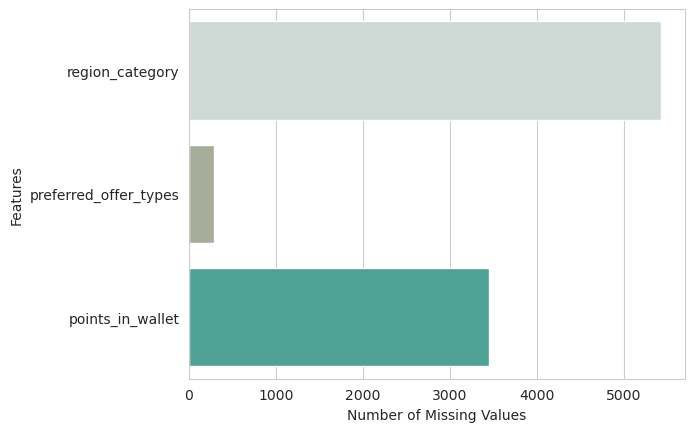

In [9]:
plot_missing_values(df)

As we can see, the features having missing values are `region_category`, `preferred_offer_types`, and `points_in_wallet` respectively.

#### Explore the types of all features

##### Categorical features

In [10]:
def plot_unique_counts(df):
    unique_counts = df.describe(include='object').T['unique']
    unique_counts_missing = unique_counts[unique_counts > 0]
    sns.barplot(x=unique_counts_missing, y=unique_counts_missing.index, palette='Set2')
    plt.xlabel("Number of Unique Values")
    plt.ylabel("Features")
    plt.show()

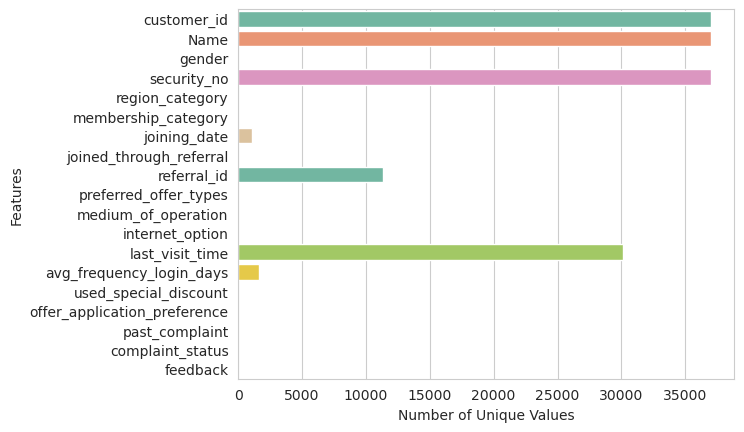

In [11]:
plot_unique_counts(df)

The reason why the categorical features are not visible in the barplot is because they have low occurrences or counts. Meanwhile, other features that have a large number of unique values in the barplot are likely to be unrelated or insignificant. Therefore, we will disregard these features:
- `customer_id`
- `Name`
- `security_no`
- `referral_id`
- `last_visit_time`

Furthermore, our observations indicate that the following features:
- `joining_date`
- `avg_frequency_login_days`

should ideally have numerical values instead of categorical values. We are going to process them later.

##### Numerical features

In [12]:
df.describe(include='number')

,age,days_since_last_login,avg_time_spent,avg_transaction_value,points_in_wallet,churn_risk_score
count,36992.000000,36992.000000,36992.000000,36992.000000,33549.000000,36992.000000
mean,37.118161,-41.915576,243.472334,29271.194003,686.882199,3.463397
std,15.867412,228.819900,398.289149,19444.806226,194.063624,1.409661
min,10.000000,-999.000000,-2814.109110,800.460000,-760.661236,-1.000000
25%,23.000000,8.000000,60.102500,14177.540000,616.150000,3.000000
50%,37.000000,12.000000,161.765000,27554.485000,697.620000,4.000000
75%,51.000000,16.000000,356.515000,40855.110000,763.950000,5.000000
max,64.000000,26.000000,3235.578521,99914.050000,2069.069761,5.000000


In [13]:
def plot_numerical_features(df, features):
    fig, axes = plt.subplots(1,len(features), figsize=(15,4))
    for i, ax in enumerate(axes.flat):
        sns.histplot(x=features[i], data=df, ax=ax, kde=True)
    plt.tight_layout()
    plt.show()

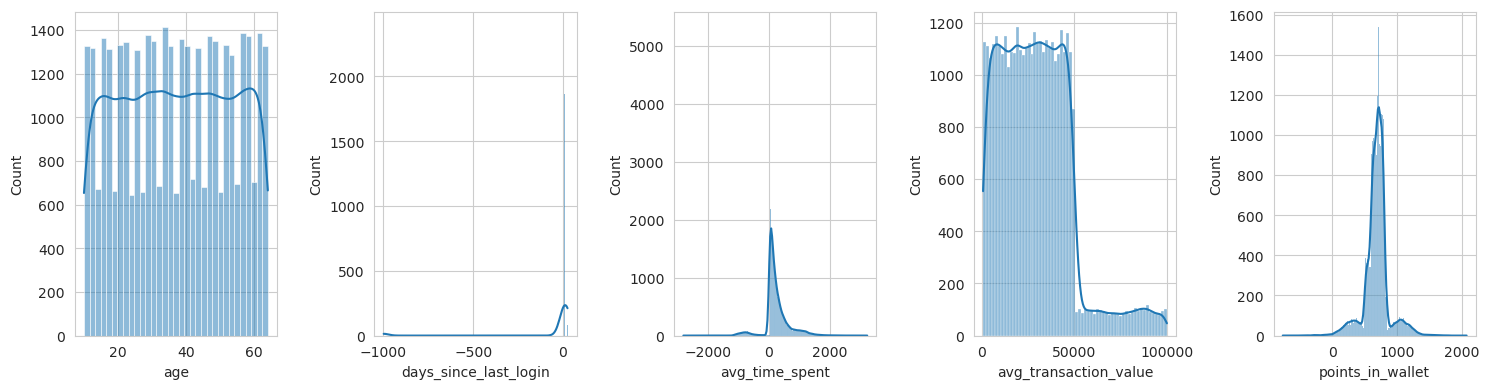

In [14]:
numerical_features = df.iloc[:,:-1].select_dtypes(include='number').columns
plot_numerical_features(df, numerical_features)

#### Visualize the distribution of target feature

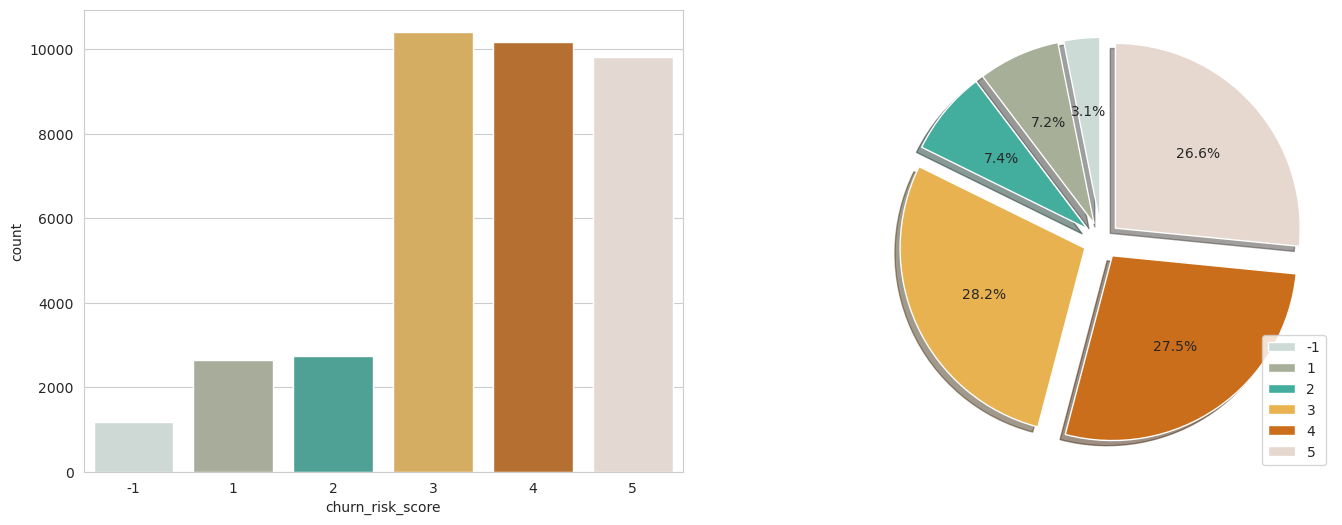

In [15]:
plt.figure(figsize=(17, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='churn_risk_score', data=df, palette=COLORS)

plt.subplot(1, 2, 2)
plt.pie(x=df['churn_risk_score'].value_counts().sort_index(), 
        autopct='%.1f%%', explode=(0.1,0.1,0.1,0.1,0.1,0.1), 
        startangle=90, shadow=True, colors=COLORS)
plt.legend(labels=['-1', '1', '2', '3', '4', '5'])
plt.show()

- After careful analysis of the provided data, it is apparent that certain records in the `churn_risk_score` column have been assigned a value of $-1$, which is not in line with the expected range of $1$ to $5$ for the score. It seems that these $-1$ values have been erroneously labeled. Our proposed course of action is to merge them with the class that has a label of $1$.

- The dataset can be considered imbalanced because the distribution of churn risk scores is not roughly equal across all $5$ labels. In this case, the majority of the records (over $80\%$) have either a churn risk score of $3$, $4$ and $5$, while the remaining scores account for a much smaller proportion of the data. This could potentially impact the performance of a machine learning model trained on this data. It may be necessary to consider strategies such as oversampling or undersampling to balance the data.

#### Other visualization

In [16]:
from matplotlib import figure
def plot_categorical_features(df, features):
    for i in features:
        print((' '+i.upper()+' ').center(50,'#'))
        display(pd.DataFrame({i: df[i].value_counts(),
                        "Ratio": round(df[i].value_counts() * 100 / len(df), 2)}))
        print("#"*50)
        plt.figure(figsize=(12, 3))
        sns.countplot(y=i,data=df, palette=COLORS)
        plt.tight_layout()
        plt.show()

##################### GENDER #####################


,gender,Ratio
F,18490,49.98
M,18443,49.86
Unknown,59,0.16


##################################################


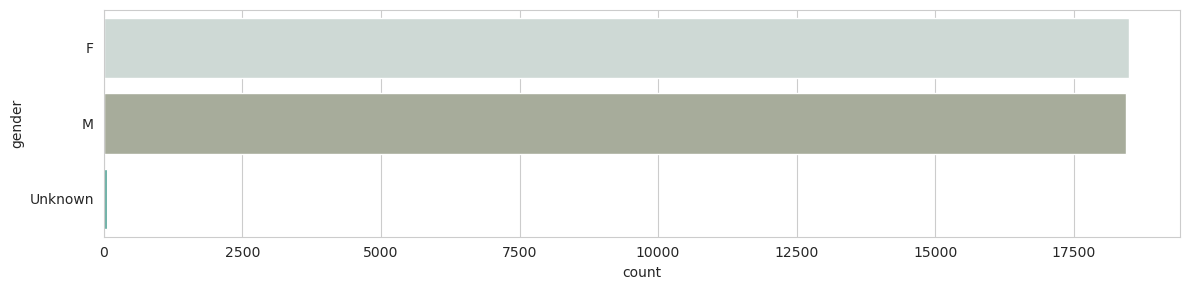

################ REGION_CATEGORY #################


,region_category,Ratio
Town,14128,38.19
City,12737,34.43
Village,4699,12.70


##################################################


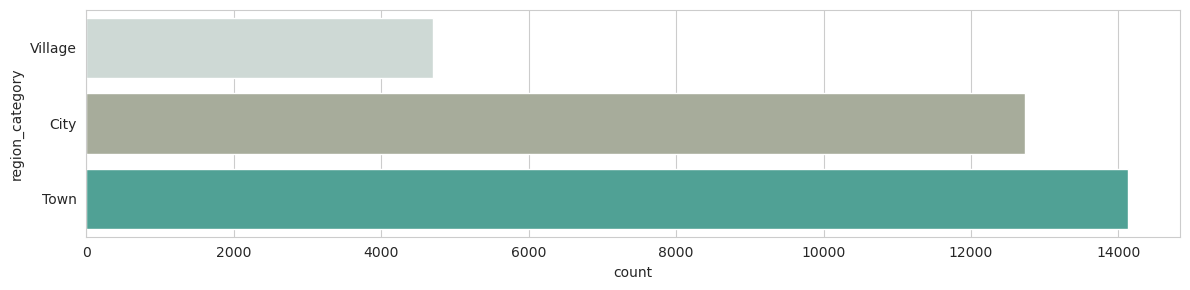

############## MEMBERSHIP_CATEGORY ###############


,membership_category,Ratio
Basic Membership,7724,20.88
No Membership,7692,20.79
Gold Membership,6795,18.37
Silver Membership,5988,16.19
Premium Membership,4455,12.04
Platinum Membership,4338,11.73


##################################################


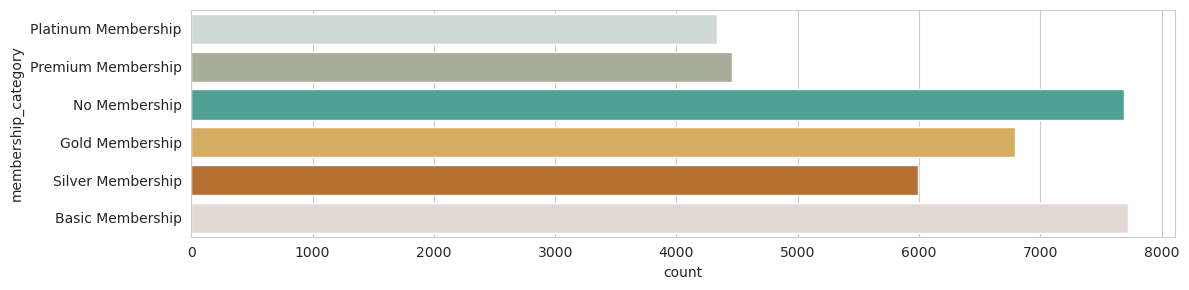

############ JOINED_THROUGH_REFERRAL #############


,joined_through_referral,Ratio
No,15839,42.82
Yes,15715,42.48
?,5438,14.70


##################################################


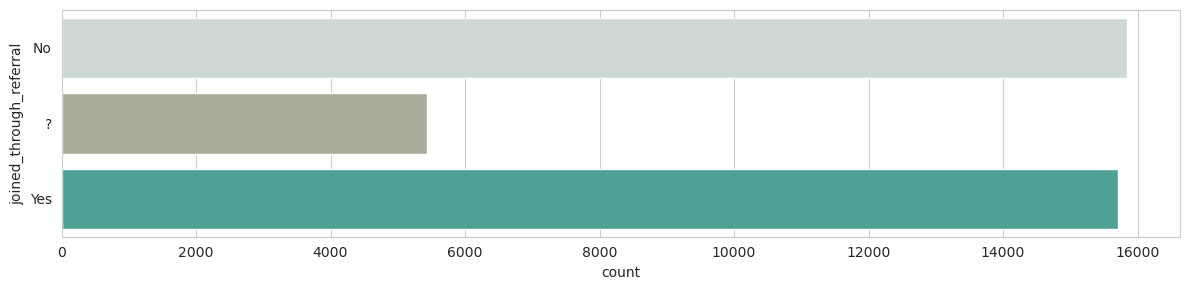

############# PREFERRED_OFFER_TYPES ##############


,preferred_offer_types,Ratio
Gift Vouchers/Coupons,12349,33.38
Credit/Debit Card Offers,12274,33.18
Without Offers,12081,32.66


##################################################


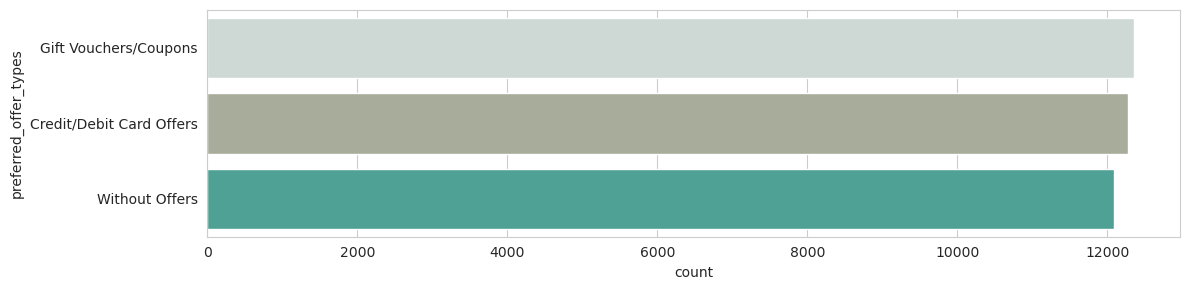

############## MEDIUM_OF_OPERATION ###############


,medium_of_operation,Ratio
Desktop,13913,37.61
Smartphone,13876,37.51
?,5393,14.58
Both,3810,10.30


##################################################


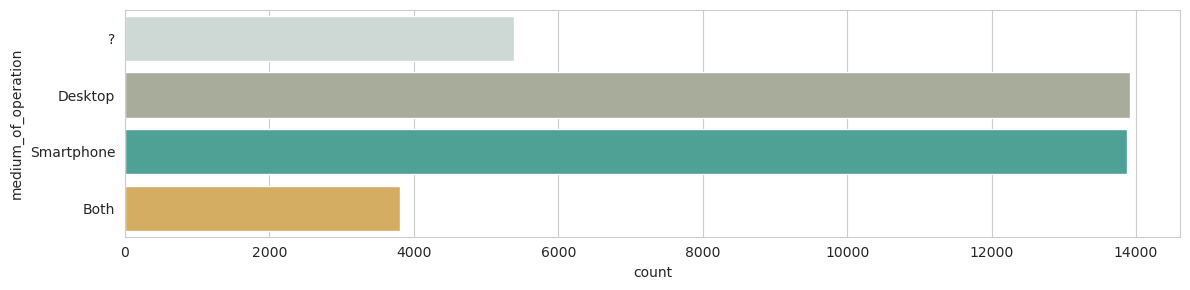

################ INTERNET_OPTION #################


,internet_option,Ratio
Wi-Fi,12413,33.56
Mobile_Data,12343,33.37
Fiber_Optic,12236,33.08


##################################################


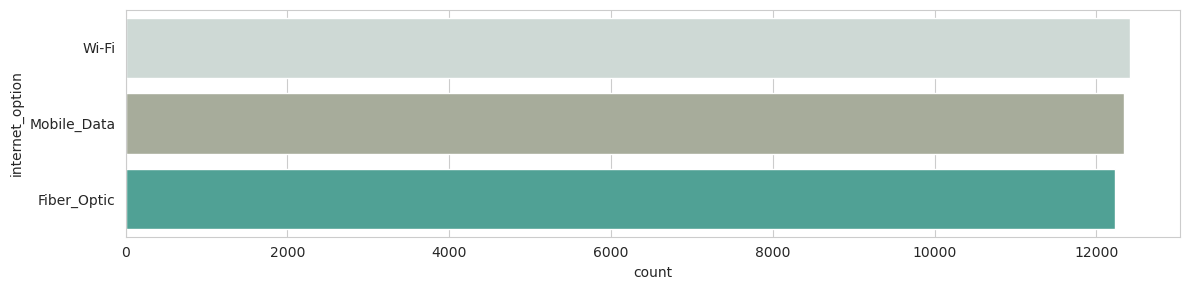

############# USED_SPECIAL_DISCOUNT ##############


,used_special_discount,Ratio
Yes,20342,54.99
No,16650,45.01


##################################################


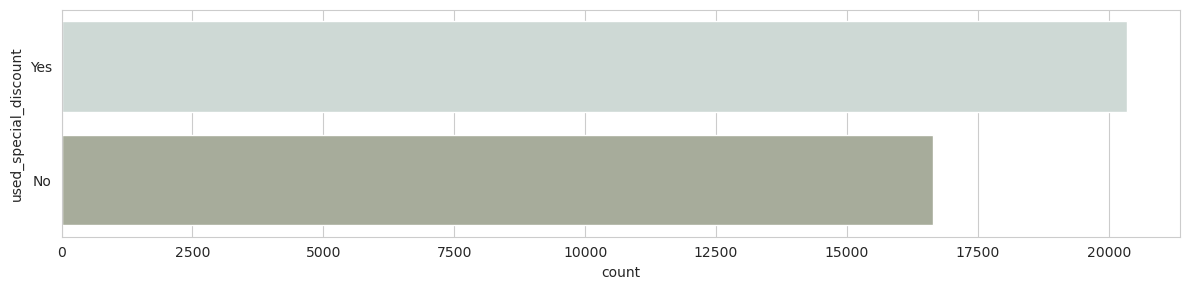

########## OFFER_APPLICATION_PREFERENCE ##########


,offer_application_preference,Ratio
Yes,20440,55.26
No,16552,44.74


##################################################


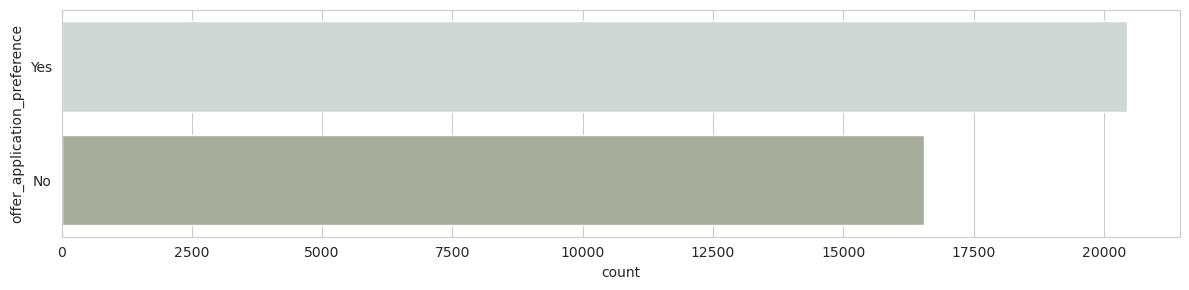

################# PAST_COMPLAINT #################


,past_complaint,Ratio
No,18602,50.29
Yes,18390,49.71


##################################################


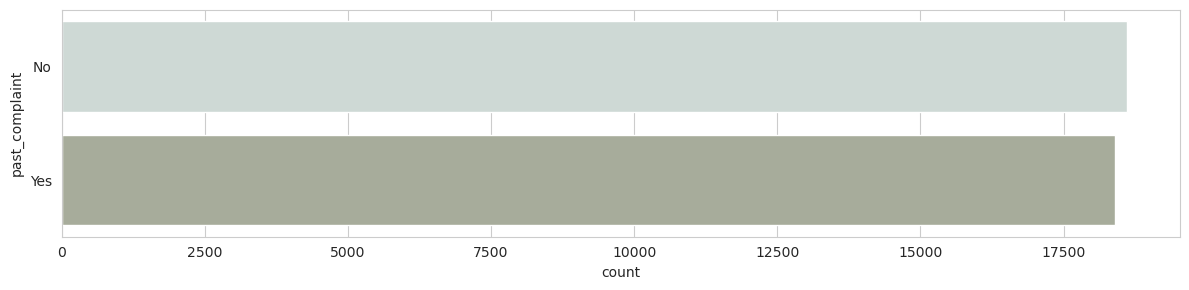

################ COMPLAINT_STATUS ################


,complaint_status,Ratio
Not Applicable,18602,50.29
Unsolved,4644,12.55
Solved,4619,12.49
Solved in Follow-up,4577,12.37
No Information Available,4550,12.30


##################################################


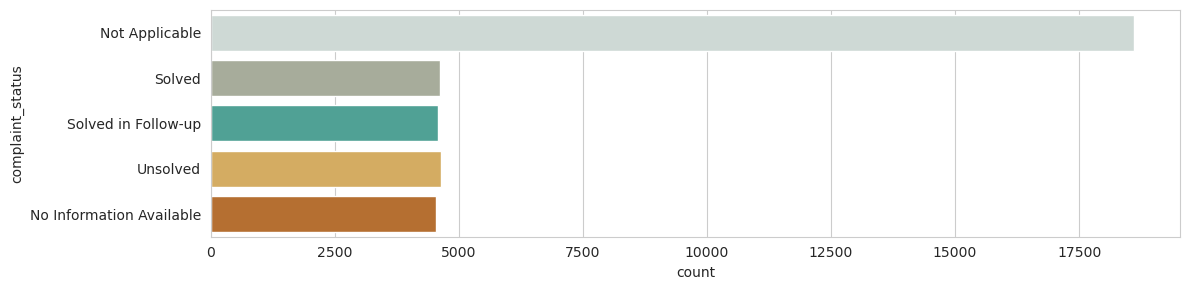

#################### FEEDBACK ####################


,feedback,Ratio
Poor Product Quality,6350,17.17
No reason specified,6290,17.00
Too many ads,6279,16.97
Poor Website,6271,16.95
Poor Customer Service,6252,16.90
Reasonable Price,1417,3.83
User Friendly Website,1391,3.76
Products always in Stock,1382,3.74
Quality Customer Care,1360,3.68


##################################################


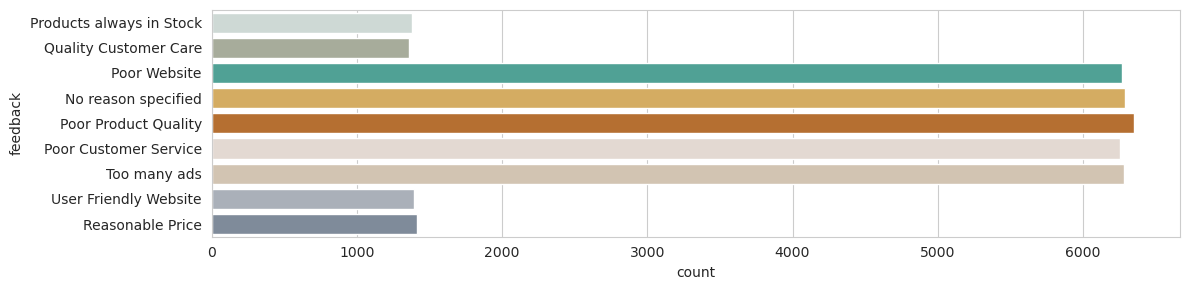

In [17]:
categorical_features = [feature for feature in df.select_dtypes(include='object').columns if feature not in ['customer_id', 'Name', 'security_no', 'joining_date', 'referral_id', 'last_visit_time', 'avg_frequency_login_days']]
plot_categorical_features(df, categorical_features)

As we can see, features containing `?` values is `joined_through_referral`, and `medium_of_operation`

Furthermore, it has come to our attention that the `feedback` feature currently consists of $9$ distinct values. To simplify the analysis, we propose reducing these values to $3$ categories as follows:
- **Positive**: `Products always in Stock`, `Quality Customer Care`, `User Friendly Website`, `Reasonable Price` 
- **Negative**: `Poor Website`, `Poor Product Quality`, `Poor Customer Service`, `Too many ads`
- **Unknown**:  `No reason specified`

To simplify the analysis, we propose reducing the `membership_category` feature into $3$ categories based on their values as follows:
- **Low Membership**: This category includes membership representing `No Membership` and `Basic Membership` respectively.
- **Medium Membership**: This category comprises membership representing `Silver Membership` and `Gold Membership` respectively.
- **High Membership**: This category includes membership levels representing `Platinum Membership` and `Premium Membership` respectively.

To simplify the analysis, we propose reducing the `complaint_status` feature into $3$ categories based on their values as follows:

- **Completed**: This category includes values `Solved` and `Solved in Follow-up`, representing cases where the issue has been resolved successfully.
- **Incomplete**: This category includes the value `Unsolved`, indicating that the issue remains unresolved.
- **Unavailable**: This category includes values `Not Applicable` and `No Information Available`, indicating that the information regarding the status of the issue is not applicable or not provided.

##### Check outliers

In [18]:
def plot_boxplot(df, features):
    sns.set_style("whitegrid")
    fig, axs = plt.subplots(len(features), 1, figsize=(13, 13), sharey=True)
    for i, ax in enumerate(axs.flat):
        sns.boxplot(x=features[i], data=df, palette='Purples', ax=ax)
        ax.set_xlabel(features[i])

    plt.suptitle("Check Outlier with Boxplot", y = 1, **TITLE)
    plt.tight_layout()
    plt.show()

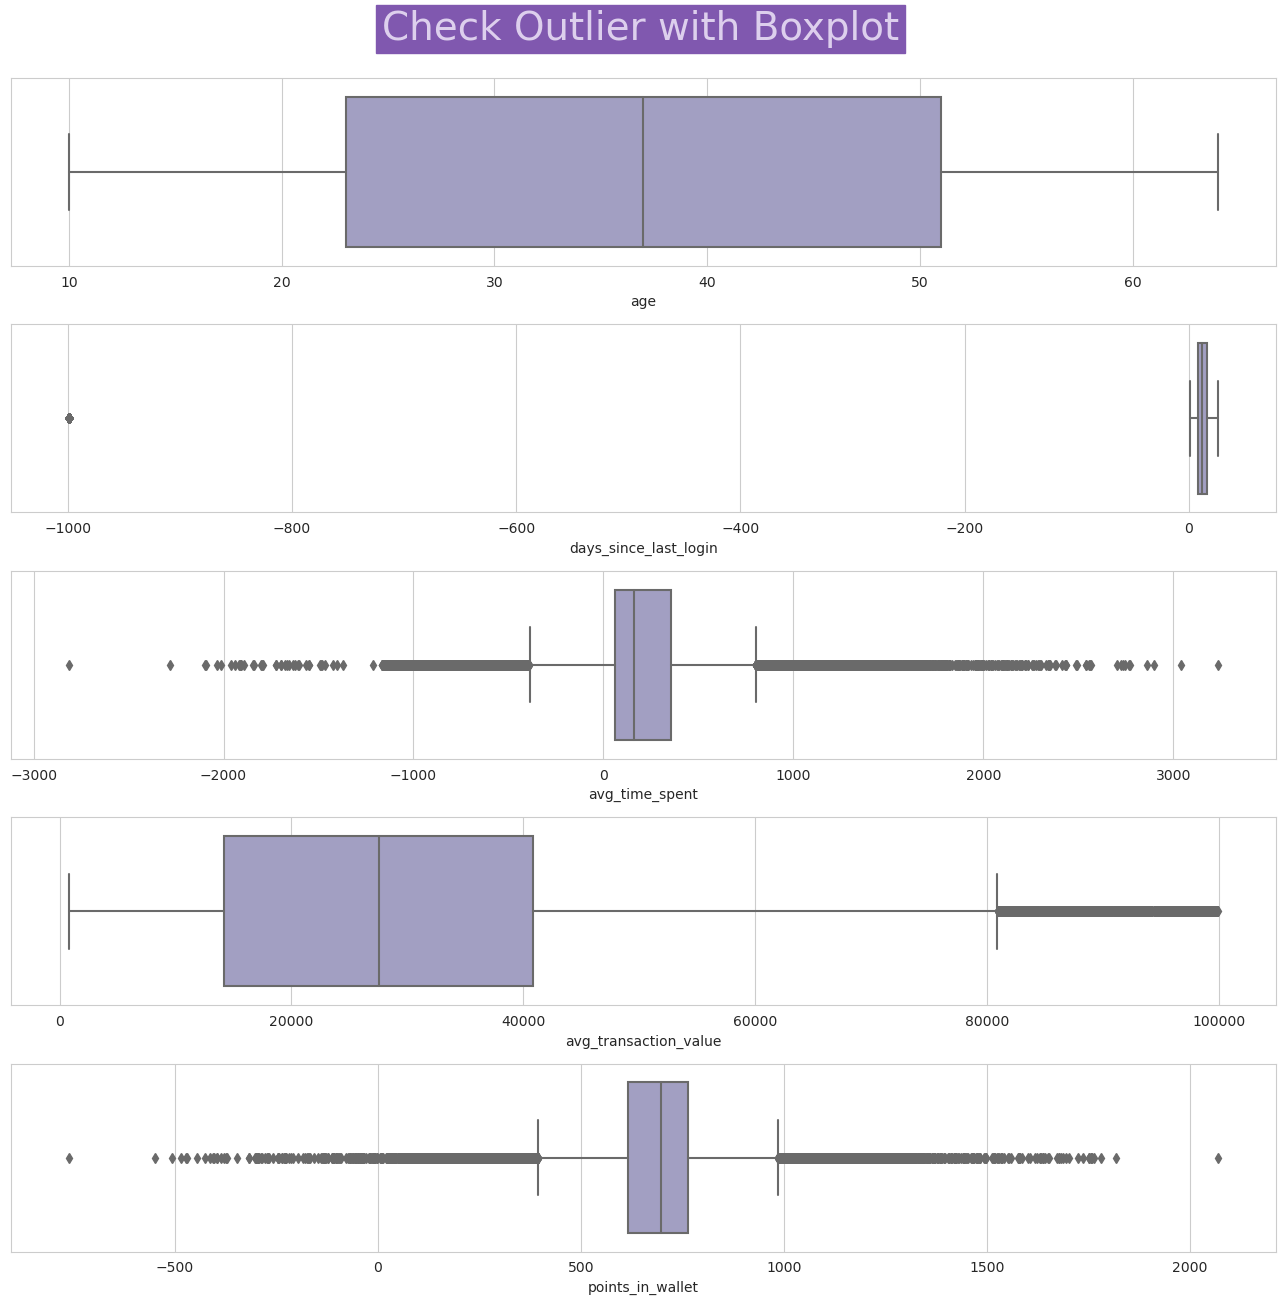

In [19]:
numerical_features = df.iloc[:,:-1].select_dtypes(include='number').columns
plot_boxplot(df, numerical_features)

Looking at the boxplots, we see that there are some outliers. We have observed that the features:
- `days_since_last_login`
- `avg_time_spent`
- `avg_transaction_value`
- `avg_frequency_login_days`
- `points_in_wallet`

should be positive values instead of negative values, so we are going to handle below.

## 3 - Preprocessing

After the data visualization step, we will proceed with the data preprocessing phase to clean and transform the dataset. This involves handling missing values, converting data types, dropping unnecessary columns, simplifying categorical features, and addressing any other data inconsistencies. These preprocessing steps aim to prepare the dataset for analysis by ensuring data quality, uniformity, and relevance.

### 3.1 Data Preprocessing

**Data Preprocessing Step**

In this step, we perform various preprocessing tasks to clean and transform the dataset. The `preprocessing_data` function is defined to encapsulate these tasks. The following operations are performed:

1. Dropping Unnecessary Columns: The columns `customer_id`, `Name`, `security_no`, `referral_id`, and `last_visit_time` are dropped from the dataset as they are deemed unnecessary.

2. Handling Missing Values: All occurrences of `'?'` in the dataset are replaced with `NaN`, which represents missing values.


3. Converting Joining Date: The `'joining_date'` column is converted from string format to datetime format using the `strptime` function. Then, the number of days since the earliest joining date in the column is calculated and stored as the new values in the `'joining_date'` column.

4. Converting Average Login Frequency: The `'avg_frequency_login_days'` column is converted to the numeric data type. Any value `'Error'` in this column is replaced with `NaN`.


5. Handling Missing Values in Categorical Columns: Missing values in each categorical column are filled with the mode (most frequent value) of that column using the `fillna` method.

6. Adjusting Churn Risk Score: The value `-1` in the `'churn_risk_score'` column is replaced with `1` to adjust the scoring.

Finally, the modified dataframe is returned.



In [20]:
def preprocessing_data(df):
    # drop unnecessary columns
    df = df.drop(['customer_id', 'Name', 'security_no', 'referral_id', 'last_visit_time'], axis=1)

    # replaces all occurrences of '?' in the dataframe with NaN (missing value)
    df.replace('?', np.NaN, inplace=True)

    # converts the 'joining_date' column from string format to datetime format
    df['joining_date'] = df['joining_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    # calculates the number of days since the earliest joining date in the 'joining_date' column
    df['joining_date'] = (df['joining_date'] - df['joining_date'].min()).dt.days

    # converts the 'avg_frequency_login_days' column to numeric data type
    df['avg_frequency_login_days'] = pd.to_numeric(df['avg_frequency_login_days'], errors='coerce')

    # fills missing values in each categorical column with the mode (most frequent value) of that column
    df['region_category'].fillna('missing', inplace=True)
    df['joined_through_referral'].fillna('missing', inplace=True)
    df['medium_of_operation'].fillna('missing', inplace=True)
    df['preferred_offer_types'].fillna('missing', inplace=True)
        
    # replaces the value -1 in the 'churn_risk_score' column with 1
#     np.random.seed(42)
#     replacement = np.random.choice([3, 4], size=df['churn_risk_score'].size, p=[0.5, 0.5])
#     df['churn_risk_score'] = np.where(df['churn_risk_score'] == -1, replacement, df['churn_risk_score'])

    return df

1. Simplifying Membership Categories: The `'membership_category'` feature is simplified into three categories. Values `'No Membership'` and `'Basic Membership'` are replaced with `'Low Membership'`, values `'Silver Membership'` and `'Gold Membership'` are replaced with `'Medium Membership'`, and values `'Platinum Membership'` and `'Premium Membership'` are replaced with `'High Membership'`.

2. Simplifying Complaint Status: The `'complaint_status'` feature is simplified into three categories. Values `'Solved'` and `'Solved in Follow-up'` are replaced with `'Completed'`, the value `'Unsolved'` is replaced with `'Incomplete'`, and values `'Not Applicable'` and `'No Information Available'` are replaced with `'Unavailable'`.

3. Simplifying Feedback: The `'feedback'` feature is simplified into three categories. Values `'Products always in Stock'`, `'Quality Customer Care'`, `'User Friendly Website'`, and `'Reasonable Price'` are replaced with `'Positive'`, values `'Poor Website'`, `'Poor Product Quality'`, `'Poor Customer Service'`, and `'Too many ads'` are replaced with `'Negative'`, and the value `'No reason specified'` is replaced with `'Unknown'`.

In [21]:
df_prep = preprocessing_data(df.copy())
df_prep

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,Platinum Membership,959,No,Gift Vouchers/Coupons,missing,Wi-Fi,17,300.630000,53005.25,17.0,781.750000,Yes,Yes,No,Not Applicable,Products always in Stock,2
1,32,F,City,Premium Membership,970,missing,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.340000,12838.38,10.0,NaN,Yes,No,Yes,Solved,Quality Customer Care,1
2,44,F,Town,No Membership,680,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.160000,21027.00,22.0,500.690000,No,Yes,Yes,Solved in Follow-up,Poor Website,5
3,37,M,City,No Membership,667,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.270000,25239.56,6.0,567.660000,No,Yes,Yes,Unsolved,Poor Website,5
4,31,F,City,No Membership,985,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.130000,24483.66,16.0,663.060000,No,Yes,Yes,Solved,Poor Website,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,F,missing,Basic Membership,994,No,Credit/Debit Card Offers,Desktop,Wi-Fi,2,-650.682759,27277.68,6.0,639.510000,No,Yes,Yes,No Information Available,No reason specified,4
36988,29,F,Town,Basic Membership,543,No,Without Offers,Smartphone,Wi-Fi,13,-638.123421,11069.71,28.0,527.990000,Yes,No,No,Not Applicable,Poor Customer Service,5
36989,23,F,missing,Basic Membership,619,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,12,154.940000,38127.56,NaN,680.470000,No,Yes,Yes,Unsolved,Poor Website,4
36990,53,M,Village,Platinum Membership,896,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,15,482.610000,2378.86,20.0,197.264414,Yes,Yes,No,Not Applicable,No reason specified,3


In [22]:
def simplify_categories(df):
    # Simplify the 'membership_category' feature into 3 categories
    df['membership_category'] = df['membership_category'].replace(['No Membership', 'Basic Membership'], 'Low Membership')
    df['membership_category'] = df['membership_category'].replace(['Silver Membership', 'Gold Membership'], 'Medium Membership')
    df['membership_category'] = df['membership_category'].replace(['Platinum Membership', 'Premium Membership'], 'High Membership')

    # Simplify the 'complaint_status' feature into 3 categories
    df['complaint_status'] = df['complaint_status'].replace(['Solved', 'Solved in Follow-up'], 'Completed')
    df['complaint_status'] = df['complaint_status'].replace('Unsolved', 'Incomplete')
    df['complaint_status'] = df['complaint_status'].replace(['Not Applicable', 'No Information Available'], 'Unavailable')

    # Simplify the 'feedback' feature into 3 categories
    df['feedback'] = df['feedback'].replace(['Products always in Stock', 'Quality Customer Care', 'User Friendly Website', 'Reasonable Price'], 'Positive')
    df['feedback'] = df['feedback'].replace(['Poor Website', 'Poor Product Quality', 'Poor Customer Service', 'Too many ads'], 'Negative')
    df['feedback'] = df['feedback'].replace('No reason specified', 'Unknown')
    
    # Simplify the 'preferred_offer_types' feature into 3 categories
    #df['preferred_offer_types'] = df['preferred_offer_types'].replace(['Gift Vouchers/Coupons', 'Credit/Debit Card Offers'], 'Yes')
    #df['preferred_offer_types'] = df['preferred_offer_types'].replace('Without Offers', 'No')

    return df

In [23]:
df_simplified = simplify_categories(df_prep)
df_simplified

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,High Membership,959,No,Gift Vouchers/Coupons,missing,Wi-Fi,17,300.630000,53005.25,17.0,781.750000,Yes,Yes,No,Unavailable,Positive,2
1,32,F,City,High Membership,970,missing,Gift Vouchers/Coupons,Desktop,Mobile_Data,16,306.340000,12838.38,10.0,NaN,Yes,No,Yes,Completed,Positive,1
2,44,F,Town,Low Membership,680,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14,516.160000,21027.00,22.0,500.690000,No,Yes,Yes,Completed,Negative,5
3,37,M,City,Low Membership,667,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11,53.270000,25239.56,6.0,567.660000,No,Yes,Yes,Incomplete,Negative,5
4,31,F,City,Low Membership,985,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20,113.130000,24483.66,16.0,663.060000,No,Yes,Yes,Completed,Negative,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,F,missing,Low Membership,994,No,Credit/Debit Card Offers,Desktop,Wi-Fi,2,-650.682759,27277.68,6.0,639.510000,No,Yes,Yes,Unavailable,Unknown,4
36988,29,F,Town,Low Membership,543,No,Without Offers,Smartphone,Wi-Fi,13,-638.123421,11069.71,28.0,527.990000,Yes,No,No,Unavailable,Negative,5
36989,23,F,missing,Low Membership,619,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,12,154.940000,38127.56,NaN,680.470000,No,Yes,Yes,Incomplete,Negative,4
36990,53,M,Village,High Membership,896,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,15,482.610000,2378.86,20.0,197.264414,Yes,Yes,No,Unavailable,Unknown,3


# 3.2 Processing Outlier

It identifies outliers in each specified feature using the IQR method. The IQR is calculated as the difference between the third quartile (Q3) and the first quartile (Q1). The lower bound and upper bound for identifying outliers are set as 1.5 times the IQR below Q1 and above Q3, respectively. Any values outside this range are replaced with NaN. The function returns the DataFrame with outliers handled.

In [24]:
def IQR_outlier(df, features):
    """
    Identify and handle outliers in the specified features using the IQR (Interquartile Range) method.
    :param df: pandas DataFrame
    :param features: list of feature column names to be processed
    :return: pandas DataFrame with outliers replaced with NaN
    """
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df.loc[~((df[feature] >= lower) & (df[feature] <= upper)), feature] = np.nan
    return df

Applies the IQR (Interquartile Range) method to handle outliers for specific features in a DataFrame. It then replaces any negative values in the numerical columns with NaN.

In [25]:
df_processed = IQR_outlier(df_simplified.copy(), features=['points_in_wallet', 'avg_frequency_login_days', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value'])

# replace values less than 0 in column with NaN
numerical_features = df_processed.iloc[:,:-1].select_dtypes(include='number').columns
for feature in numerical_features:
    df_processed[feature] = df_processed[feature].apply(lambda x: np.NaN if x < 0 else x)

Uses the KNNImputer from scikit-learn to impute missing values in specific features of the DataFrame. It iterates through the selected features, applies the KNN imputation to each feature individually, and replaces the missing values with the imputed values.

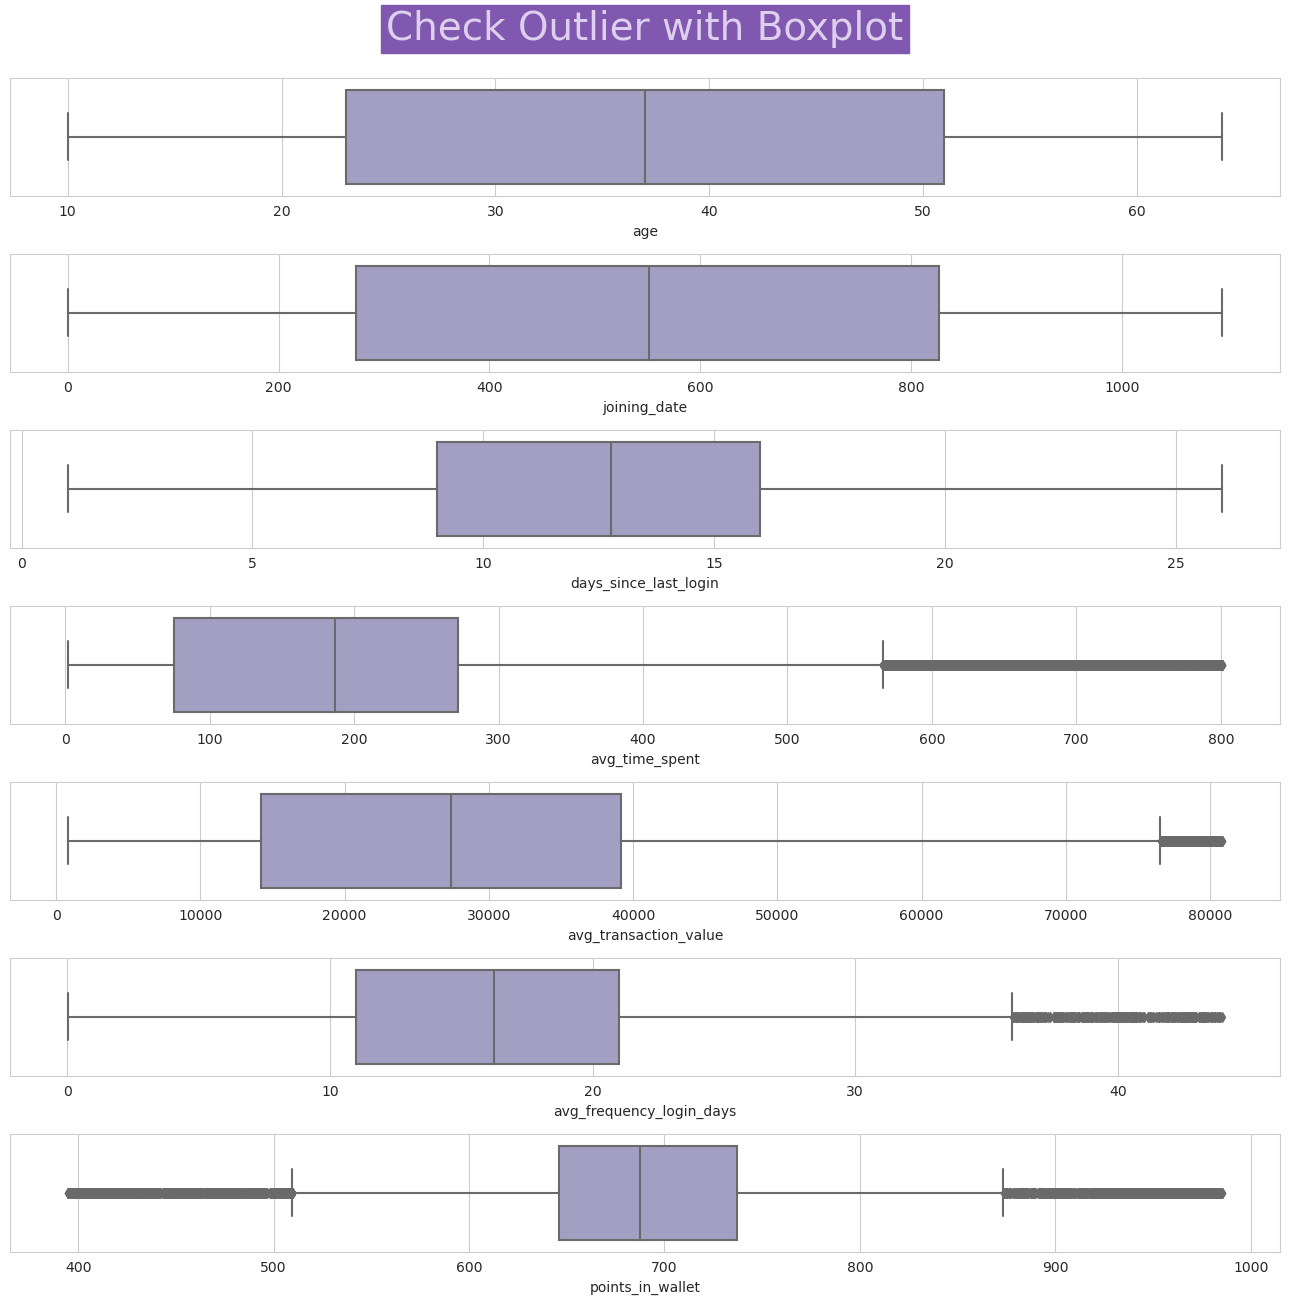

In [26]:
from sklearn.impute import SimpleImputer
features=['points_in_wallet', 'avg_frequency_login_days', 'days_since_last_login', 'avg_time_spent', 'avg_transaction_value']
for feature in features:
    imputer = KNNImputer()
    column_data = df_processed[[feature]].values
    imputed_column_data = imputer.fit_transform(column_data)
    df_processed[feature] = imputed_column_data
    
plot_boxplot(df_processed, numerical_features)

In [27]:
df_processed

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,F,Village,High Membership,959,No,Gift Vouchers/Coupons,missing,Wi-Fi,17.0,300.63000,53005.25,17.0000,781.750000,Yes,Yes,No,Unavailable,Positive,2
1,32,F,City,High Membership,970,missing,Gift Vouchers/Coupons,Desktop,Mobile_Data,16.0,306.34000,12838.38,10.0000,687.396149,Yes,No,Yes,Completed,Positive,1
2,44,F,Town,Low Membership,680,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,14.0,516.16000,21027.00,22.0000,500.690000,No,Yes,Yes,Completed,Negative,5
3,37,M,City,Low Membership,667,Yes,Gift Vouchers/Coupons,Desktop,Mobile_Data,11.0,53.27000,25239.56,6.0000,567.660000,No,Yes,Yes,Incomplete,Negative,5
4,31,F,City,Low Membership,985,No,Credit/Debit Card Offers,Smartphone,Mobile_Data,20.0,113.13000,24483.66,16.0000,663.060000,No,Yes,Yes,Completed,Negative,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,F,missing,Low Membership,994,No,Credit/Debit Card Offers,Desktop,Wi-Fi,2.0,209.04823,27277.68,6.0000,639.510000,No,Yes,Yes,Unavailable,Unknown,4
36988,29,F,Town,Low Membership,543,No,Without Offers,Smartphone,Wi-Fi,13.0,209.04823,11069.71,28.0000,527.990000,Yes,No,No,Unavailable,Negative,5
36989,23,F,missing,Low Membership,619,Yes,Gift Vouchers/Coupons,Desktop,Wi-Fi,12.0,154.94000,38127.56,16.2558,680.470000,No,Yes,Yes,Incomplete,Negative,4
36990,53,M,Village,High Membership,896,No,Gift Vouchers/Coupons,Smartphone,Mobile_Data,15.0,482.61000,2378.86,20.0000,687.396149,Yes,Yes,No,Unavailable,Unknown,3


##################### GENDER #####################


,gender,Ratio
F,18490,49.98
M,18443,49.86
Unknown,59,0.16


##################################################


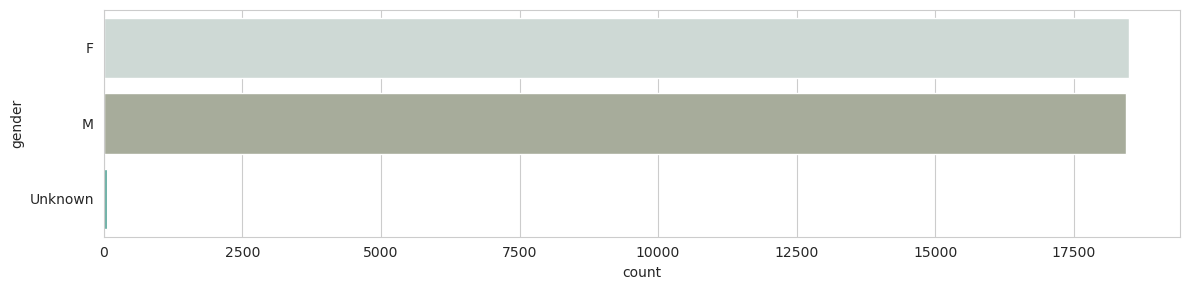

################ REGION_CATEGORY #################


,region_category,Ratio
Town,14128,38.19
City,12737,34.43
Village,4699,12.70


##################################################


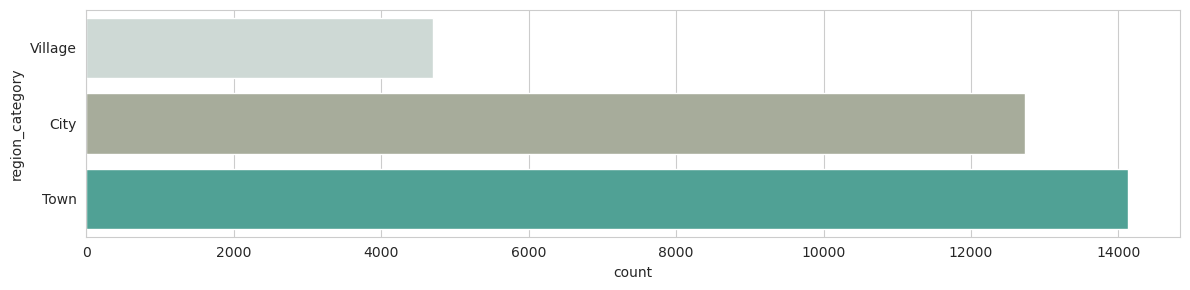

############## MEMBERSHIP_CATEGORY ###############


,membership_category,Ratio
Basic Membership,7724,20.88
No Membership,7692,20.79
Gold Membership,6795,18.37
Silver Membership,5988,16.19
Premium Membership,4455,12.04
Platinum Membership,4338,11.73


##################################################


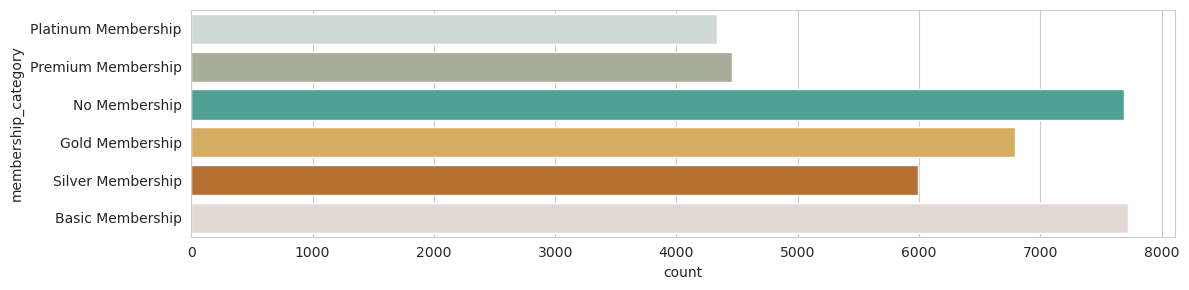

############ JOINED_THROUGH_REFERRAL #############


,joined_through_referral,Ratio
No,15839,42.82
Yes,15715,42.48
?,5438,14.70


##################################################


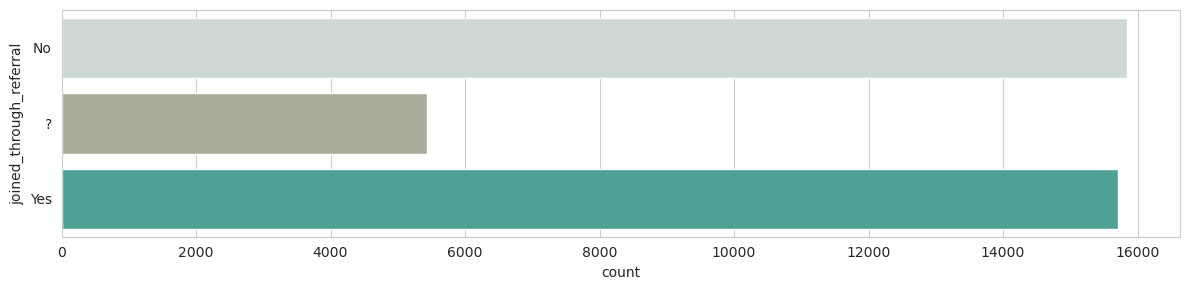

############# PREFERRED_OFFER_TYPES ##############


,preferred_offer_types,Ratio
Gift Vouchers/Coupons,12349,33.38
Credit/Debit Card Offers,12274,33.18
Without Offers,12081,32.66


##################################################


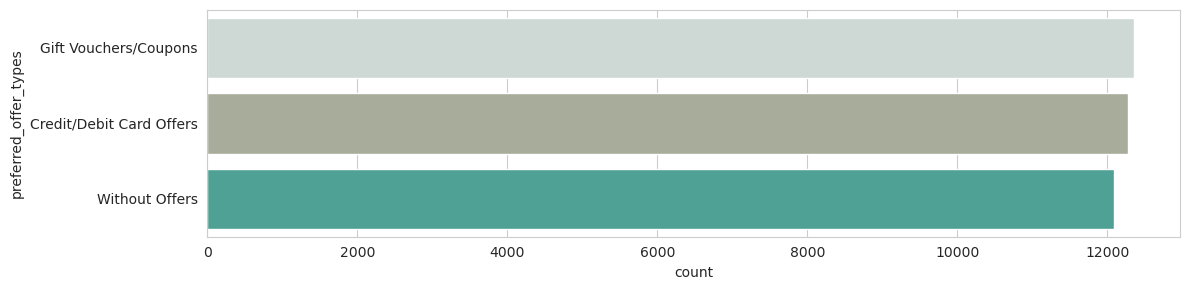

############## MEDIUM_OF_OPERATION ###############


,medium_of_operation,Ratio
Desktop,13913,37.61
Smartphone,13876,37.51
?,5393,14.58
Both,3810,10.30


##################################################


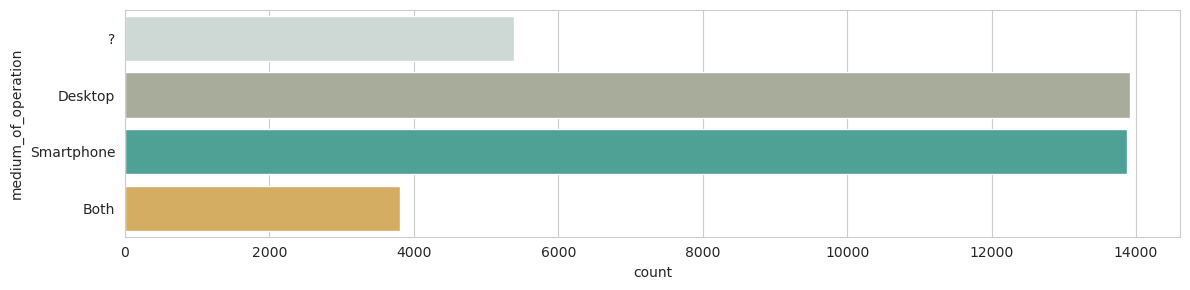

################ INTERNET_OPTION #################


,internet_option,Ratio
Wi-Fi,12413,33.56
Mobile_Data,12343,33.37
Fiber_Optic,12236,33.08


##################################################


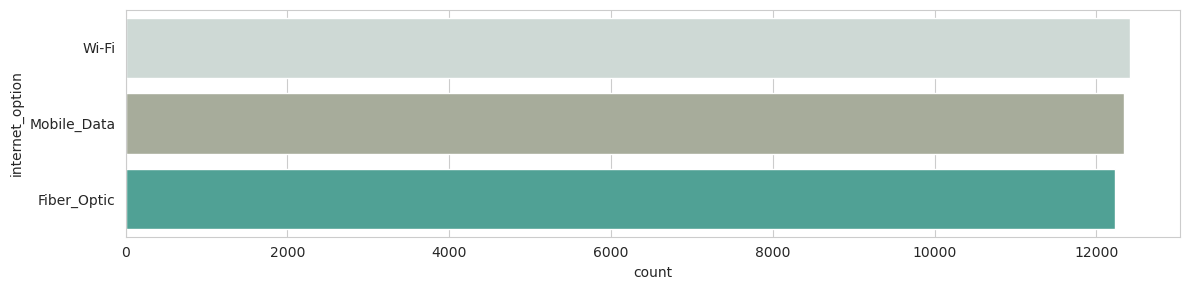

############# USED_SPECIAL_DISCOUNT ##############


,used_special_discount,Ratio
Yes,20342,54.99
No,16650,45.01


##################################################


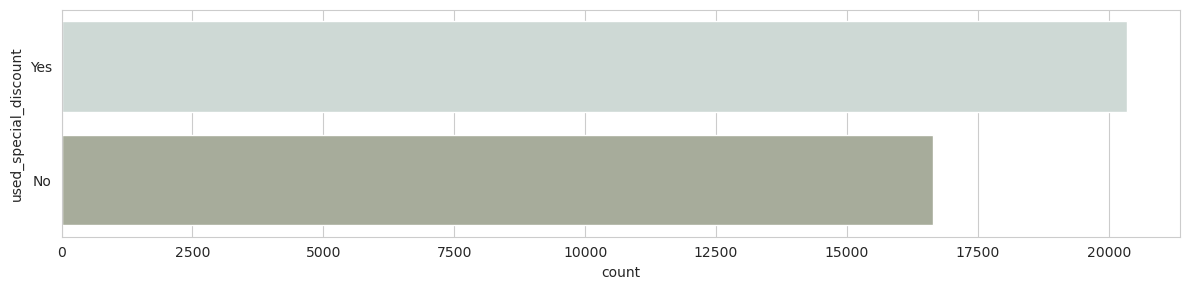

########## OFFER_APPLICATION_PREFERENCE ##########


,offer_application_preference,Ratio
Yes,20440,55.26
No,16552,44.74


##################################################


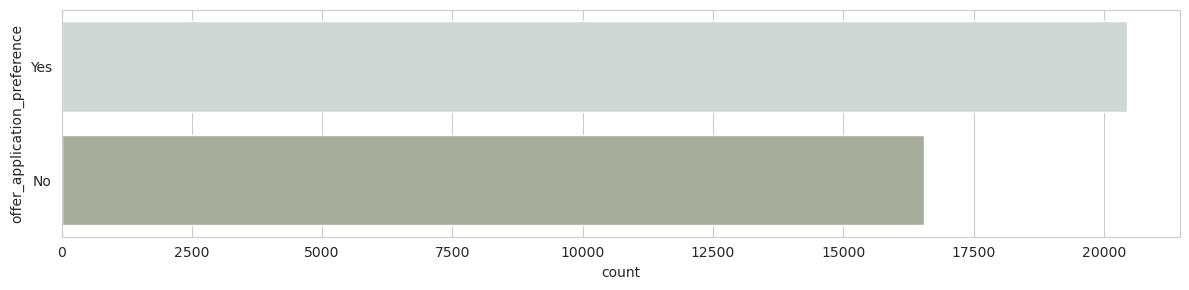

################# PAST_COMPLAINT #################


,past_complaint,Ratio
No,18602,50.29
Yes,18390,49.71


##################################################


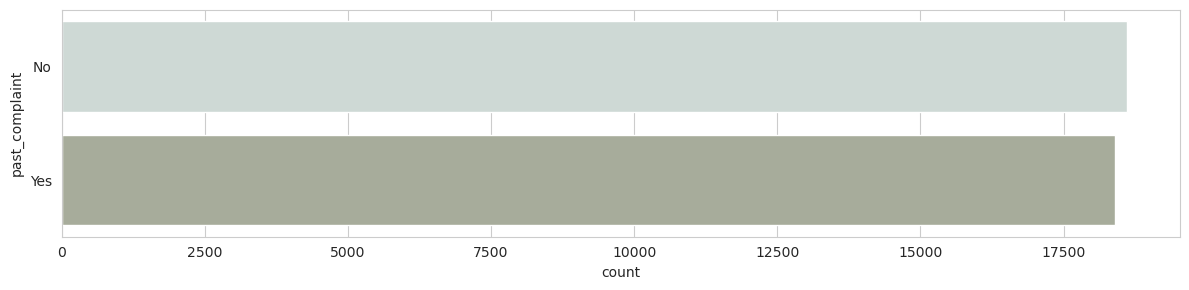

################ COMPLAINT_STATUS ################


,complaint_status,Ratio
Not Applicable,18602,50.29
Unsolved,4644,12.55
Solved,4619,12.49
Solved in Follow-up,4577,12.37
No Information Available,4550,12.30


##################################################


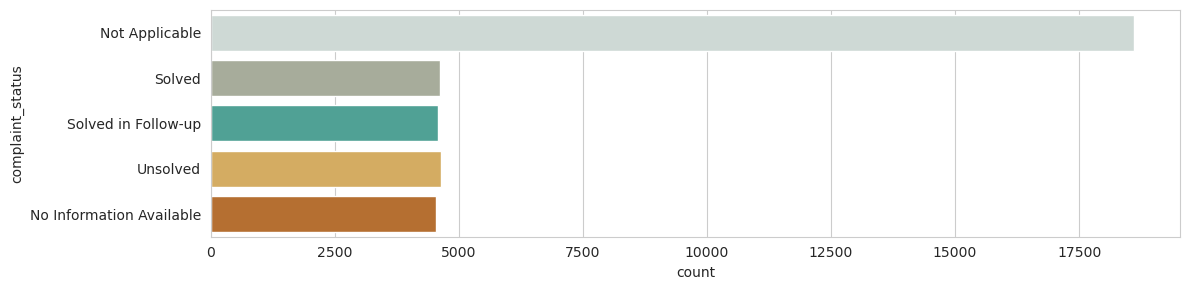

#################### FEEDBACK ####################


,feedback,Ratio
Poor Product Quality,6350,17.17
No reason specified,6290,17.00
Too many ads,6279,16.97
Poor Website,6271,16.95
Poor Customer Service,6252,16.90
Reasonable Price,1417,3.83
User Friendly Website,1391,3.76
Products always in Stock,1382,3.74
Quality Customer Care,1360,3.68


##################################################


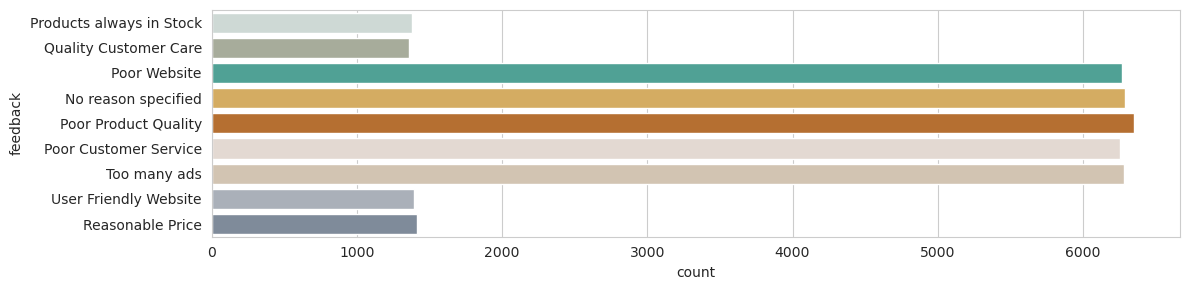

In [28]:
plot_categorical_features(df, categorical_features)

# 4 - Feature Engineering

In [29]:
def apply_feature_engineering(df):
    """
    Apply all feature engineering to transform your data into number
    :param df: pandas DataFrame
    :return: pandas DataFrame
    """
    # Todo: Normalize your data
    for feature in df.select_dtypes(include='object').columns:
        if feature == 'membership_category':
            rank = {'Low Membership': 0, 
                    'Medium Membership': 1, 
                    'High Membership': 2}
            df['membership_category'] = df['membership_category'].replace(rank)

        else:
            df[feature] = df[feature].astype('category').cat.codes
    return df

In [30]:
df_cleaned = apply_feature_engineering(df_processed.copy())

In [31]:
df_cleaned

,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,0,2,2,959,0,1,3,2,17.0,300.63000,53005.25,17.0000,781.750000,1,1,0,2,1,2
1,32,0,0,2,970,2,1,1,1,16.0,306.34000,12838.38,10.0000,687.396149,1,0,1,0,1,1
2,44,0,1,0,680,1,1,1,2,14.0,516.16000,21027.00,22.0000,500.690000,0,1,1,0,0,5
3,37,1,0,0,667,1,1,1,1,11.0,53.27000,25239.56,6.0000,567.660000,0,1,1,1,0,5
4,31,0,0,0,985,0,0,2,1,20.0,113.13000,24483.66,16.0000,663.060000,0,1,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36987,46,0,3,0,994,0,0,1,2,2.0,209.04823,27277.68,6.0000,639.510000,0,1,1,2,2,4
36988,29,0,1,0,543,0,2,2,2,13.0,209.04823,11069.71,28.0000,527.990000,1,0,0,2,0,5
36989,23,0,3,0,619,1,1,1,2,12.0,154.94000,38127.56,16.2558,680.470000,0,1,1,1,0,4
36990,53,1,2,2,896,0,1,2,1,15.0,482.61000,2378.86,20.0000,687.396149,1,1,0,2,2,3


<Axes: >

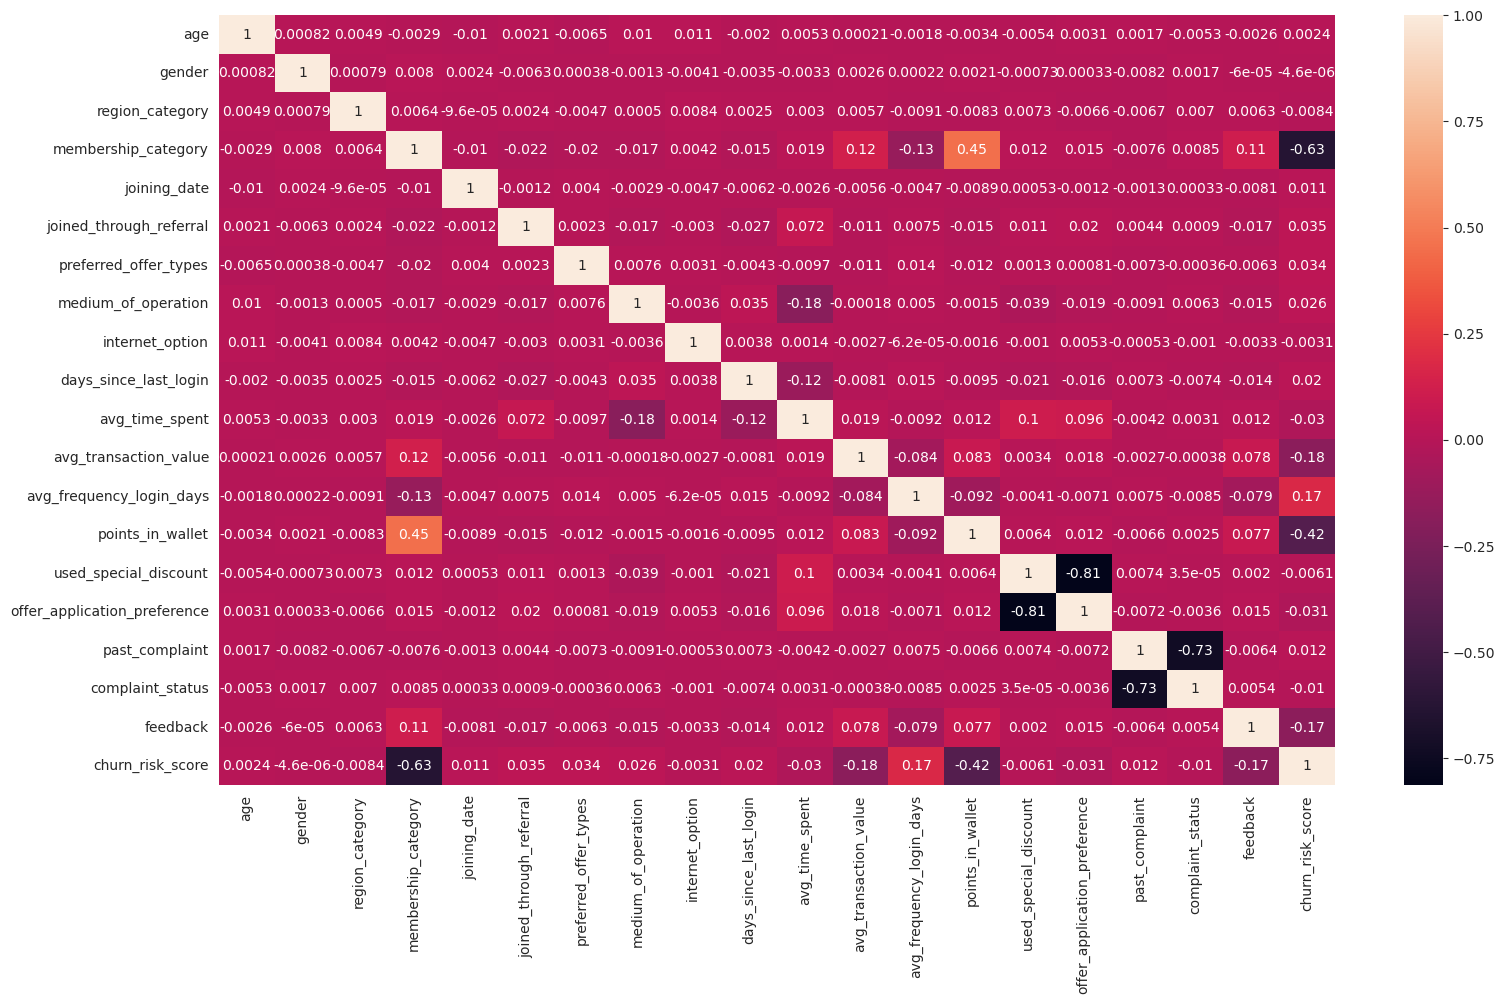

In [32]:
plt.figure(figsize=(18,10))
sns.heatmap(df_cleaned.corr(), annot = True) # Show heatmap after normalized data

In [33]:
dict = {}
for i in list(df_cleaned.columns):
    dict[i] = df_cleaned[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).T

,unique count
age,55
gender,3
region_category,4
membership_category,3
joining_date,1096
joined_through_referral,3
preferred_offer_types,4
medium_of_operation,4
internet_option,3
days_since_last_login,27


# Feature engineering

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.tree import DecisionTreeClassifier

# Tách thành hai bộ dữ liệu
df_labeled = df_cleaned[df_cleaned['churn_risk_score'] != -1]
df_unlabeled = df_cleaned[df_cleaned['churn_risk_score'] == -1]

# Xóa cột 'churn_risk_score' khỏi bộ dữ liệu labeled
X = df_labeled.drop('churn_risk_score', axis=1)
y = df_labeled['churn_risk_score']

# Tạo pipeline với StandardScaler và DecisionTreeClassifier
pipeline = make_pipeline(RobustScaler(), DecisionTreeClassifier())

# Huấn luyện mô hình
pipeline.fit(X, y)

# Dự đoán giá trị cho bộ dữ liệu không có nhãn
X_unlabeled = df_unlabeled.drop('churn_risk_score', axis=1)
predicted_labels = pipeline.predict(X_unlabeled)

# Gán các giá trị dự đoán vào bộ dữ liệu ban đầu
df_unlabeled['churn_risk_score'] = predicted_labels

# Kết hợp bộ dữ liệu labeled và unlabeled lại
df_final = pd.concat([df_labeled, df_unlabeled])

df_final

/tmp/ipykernel_20/753298777.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unlabeled['churn_risk_score'] = predicted_labels


,age,gender,region_category,membership_category,joining_date,joined_through_referral,preferred_offer_types,medium_of_operation,internet_option,days_since_last_login,avg_time_spent,avg_transaction_value,avg_frequency_login_days,points_in_wallet,used_special_discount,offer_application_preference,past_complaint,complaint_status,feedback,churn_risk_score
0,18,0,2,2,959,0,1,3,2,17.0,300.63,53005.25,17.0,781.750000,1,1,0,2,1,2
1,32,0,0,2,970,2,1,1,1,16.0,306.34,12838.38,10.0,687.396149,1,0,1,0,1,1
2,44,0,1,0,680,1,1,1,2,14.0,516.16,21027.00,22.0,500.690000,0,1,1,0,0,5
3,37,1,0,0,667,1,1,1,1,11.0,53.27,25239.56,6.0,567.660000,0,1,1,1,0,5
4,31,0,0,0,985,0,0,2,1,20.0,113.13,24483.66,16.0,663.060000,0,1,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36835,13,1,1,0,6,0,2,2,0,12.0,102.89,16279.77,6.0,546.190000,1,0,1,2,2,5
36849,45,1,1,1,114,0,2,2,2,14.0,291.70,18911.05,18.0,700.090000,0,1,0,2,0,4
36859,53,0,3,0,317,1,2,2,0,10.0,95.96,27865.26,6.0,687.396149,0,1,0,2,0,4
36863,30,0,2,0,613,1,0,0,0,13.0,536.39,45566.67,25.0,511.730000,1,0,0,2,0,5


In [35]:
def prepare_X_y(df):
    """
    Feature engineering and create X and y
    :param df: pandas dataframe
    :return: (X, y) output feature matrix (dataframe), target (series)
    """
    # Todo: Split data into X and y (using sklearn train_test_split). Return two dataframes
    feature_names = df.columns.tolist()
    feature_names.remove("churn_risk_score")

    X = df[feature_names].values
    y = df.churn_risk_score.values
    return X, y

X, y = prepare_X_y(df_final)

RANDOM_STATE = 26012002
TRAIN_SIZE = 0.75

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

## 5 - Model

In [36]:
# class_labels = [1, 2, 3, 4, 5]
# class_counts = np.unique(y_train, return_counts=True)[1]

# total_samples = sum(class_counts)
# class_weights = {label: total_samples / count for label, count in zip(class_labels, class_counts)}

In [37]:
%%time
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svc = SVC(probability=True, class_weight = 'balanced', random_state=RANDOM_STATE)
pipe = Pipeline(steps=[("scaler", RobustScaler()),("clf", svc)]) 

param_grid = [ {'clf__kernel': ['rbf'], 
               'clf__gamma': ['scale', 'auto'],
               'clf__C': [.1, 1, 2]},
              {'clf__kernel': ['linear'],
               'clf__C': [.1, 1, 10]} ]

model = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)

model.fit(X_train, y_train)

CPU times: user 1min 29s, sys: 437 ms, total: 1min 29s
Wall time: 25min 20s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('clf',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=26012002))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0.1, 1, 2],
                          'clf__gamma': ['scale', 'auto'],
                          'clf__kernel': ['rbf']},
                         {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear']}])

In [38]:
pred = model.predict(X_test)

In [39]:
print("Classification report: \n", classification_report(y_test , pred))

Classification report: 
               precision    recall  f1-score   support

           1       0.70      0.62      0.66       691
           2       0.68      0.76      0.72       726
           3       0.94      0.86      0.90      2643
           4       0.76      0.44      0.56      2638
           5       0.66      1.00      0.79      2550

    accuracy                           0.75      9248
   macro avg       0.75      0.73      0.72      9248
weighted avg       0.77      0.75      0.74      9248



In [40]:
print(model.best_params_)

{'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}
